<a href="https://colab.research.google.com/github/vaibhavdusad/Assignment-1/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
import torch.optim as optim
from torch.autograd import variable
import matplotlib.pyplot as plt
import time
from torch.autograd import Variable
import torchvision


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
applytransform=transforms.Compose([transforms.ToTensor()])
TrainMnist = datasets.MNIST('/MNIST',train=True,download=True,transform=applytransform)
TestMnist = datasets.MNIST('MNIST',train=False,download=True,transform=applytransform)

In [0]:
class EncoderNet(nn.Module):
  def __init__(self):
    super(EncoderNet,self).__init__()
    self.fc1 = nn.Linear(784,400)
    self.fc2 = nn.Linear(400,100)
    self.fc3 = nn.Linear(100,2)
  def forward(self,x):
    x = x.view(-1,784)
    x = torch.sigmoid(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [0]:
class DecoderNet(nn.Module):
  def __init__(self):
    super(DecoderNet,self).__init__()
    self.fc1 = nn.Linear(2,100)
    self.fc2 = nn.Linear(100,400)
    self.fc3 = nn.Linear(400,784)
  def forward(self,x):
    x = torch.sigmoid(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    x = x.view(-1,1,28,28)
    return x

In [0]:
class DiscriminatorNet(nn.Module):
  def __init__(self):
    super(DiscriminatorNet,self).__init__()
    self.fc1 = nn.Linear(2,10)
    self.fc2 = nn.Linear(10,10)
    self.fc3 = nn.Linear(10,2)
  def forward(self,x):
    x = torch.sigmoid(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [0]:
encoder = EncoderNet().cuda()
decoder = DecoderNet().cuda()
disc = DiscriminatorNet().cuda()

In [0]:
criterion1 = nn.MSELoss()
criterion2 = nn.BCELoss()
optimizer1 = optim.Adam(encoder.parameters(),lr = 1e-2)
optimizer2 = optim.Adam(decoder.parameters(),lr = 1e-2)
optimizer3 = optim.Adam(disc.parameters(),lr = 1e-2)

In [0]:
batchsize = 96

In [0]:
Trainloader=torch.utils.data.DataLoader(TrainMnist,batch_size=batchsize,shuffle=True,num_workers=4)
Testloader=torch.utils.data.DataLoader(TestMnist,batch_size=batchsize,shuffle=True,num_workers=4)

In [22]:
for epoch in range(10):
  trainingloss = []
  runningloss = 0
  adversarial_loss = 0
  reconstruction_loss = 0

  disc.train(True)
  for data in Trainloader:
    
    inputs,_ = data
    inputs = Variable(inputs.cuda())
    
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    

    outputsencoder = encoder(inputs) #Encoder Output
    outputs = decoder(outputsencoder)    #Decoder Output
    loss = criterion1(outputs,inputs) #Loss
    loss.backward(retain_graph=True)
    optimizer2.step() #Optimizing decoder

    optimizer1.zero_grad()
    optimizer3.zero_grad() 
    
    real_inputs = Variable(torch.tensor(np.random.normal(size = [batchsize,2])).float().cuda())    
    one = torch.ones(batchsize,2).float()
    zero = torch.zeros(batchsize,2).float()
    labels1 = Variable(one.cuda())
    labels2 = Variable(zero.cuda())    
    
    fake_data = disc(outputsencoder) #Discriminator output for fake_data
    real_data = disc(real_inputs)   #Discriminator output for Real_Data
            
    loss_real = criterion2(real_data,labels1)
    loss_fake = criterion2(fake_data,labels2)    
    lossnew = loss_real + loss_fake  
    lossnew.backward(retain_graph=True) #loss_discriminator
    optimizer3.step()
    lossenc = loss - lossnew*(0.01) #loss_encoder
    lossenc.backward(retain_graph=True)
    optimizer1.step()
    
    #adversarial_loss += lossenc.data.item()
    reconstruction_loss += loss.data.item()
  #totaladloss = adversarial_loss/625
  totalreloss = reconstruction_loss/625
  print(decoder.fc2.weight.data)
  print("Adverserial loss : %  and Reconstruction loss = %",(totaladloss,totalreloss))

tensor([[-0.2370, -0.1237, -0.1024,  ..., -0.1154, -0.1788, -0.1247],
        [-0.1306, -0.1839, -0.2407,  ..., -0.1277, -0.2284, -0.1130],
        [-0.2518, -0.1845, -0.1399,  ..., -0.2229, -0.2086, -0.1940],
        ...,
        [-0.0803, -0.1752, -0.2631,  ..., -0.2267, -0.1243, -0.1815],
        [-0.2463, -0.0932, -0.1870,  ..., -0.1167, -0.0894, -0.2651],
        [-0.2724, -0.1838, -0.2440,  ..., -0.1461, -0.1237, -0.2235]],
       device='cuda:0')
Adverserial loss : %  and Reconstruction loss = % (-0.20897905838489533, 0.0720263421535492)
tensor([[-0.2394, -0.1264, -0.1055,  ..., -0.1175, -0.1813, -0.1272],
        [-0.1331, -0.1866, -0.2440,  ..., -0.1299, -0.2311, -0.1155],
        [-0.2539, -0.1868, -0.1426,  ..., -0.2248, -0.2109, -0.1962],
        ...,
        [-0.0818, -0.1770, -0.2651,  ..., -0.2282, -0.1258, -0.1833],
        [-0.2482, -0.0955, -0.1896,  ..., -0.1185, -0.0914, -0.2672],
        [-0.2740, -0.1856, -0.2461,  ..., -0.1477, -0.1253, -0.2253]],
       device='

In [0]:
def imshow(img):
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()

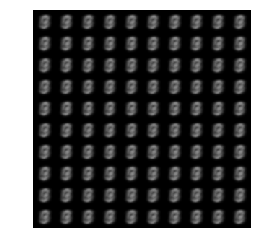

In [20]:
#Testing
testinputs = Variable(torch.tensor(np.random.normal(size = [100,2])).float().cuda())
testoutputs = decoder(disc(testinputs))
imshow(torchvision.utils.make_grid(testoutputs[:100],nrow=10))